In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
# Loop through and load in artifacts, signal, and do SWR wavelet
training_sessions = [['Rey', 'training'],['Han','training'],['Django', 'training'], ['Finn2', 'training'],['Rose', 'training'], ['Jyn','training']]
ripple_channels = [26, 8, 59, 7, 25, 18]
ripple_range = np.arange(125, 275, 5)
rec_list = []

for (animal, sess_name), ripple_channel in zip(training_sessions, ripple_channels):
    
    sess_dir = get_session_dir(animal, sess_name)
    sess = sess_use(sess_dir)
    art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
    sess.art_epochs = Epoch(epochs=None, file=art_epochs_file)
    signal = sess.eegfile.get_signal()
    sess.wv_ripple = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), 
                              freqs=ripple_range, sigma=None)
    
    rec_list.append(sess)
rec_list
# print(sess.recinfo)

[ProcessData(Rey_training_denoised.xml),
 ProcessData(Han_training.xml),
 ProcessData(Django_training_denoised.xml),
 ProcessData(Finn2_training_denoised.xml),
 ProcessData(Rose_training_denoised.xml),
 ProcessData(Jyn_training_denoised.xml)]

In [4]:
# Import USVs
usv_list = []
for sess in rec_list:
    # Import USV epochs (from Sync_USV_and_Ephys notebook).
    usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
    usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
    usv_list.append(usv_epochs)

In [5]:
usv_epochs

16 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  870.126212  870.171338  505.926529  47.944444  0.045134   27.777778    1.0   
1  871.160586  871.233890  506.961084  45.345779  0.073317   25.343152    1.0   
2  871.556279  871.597182  507.356846  50.209416  0.040911    5.905844    1.0   
3  871.961179  872.056770  507.761818  46.842283  0.095608    5.095238    1.0   
4  872.405570  872.475605  508.206287  45.924784  0.070048    5.326840    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

In [6]:
ripple_range

array([125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185,
       190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250,
       255, 260, 265, 270])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

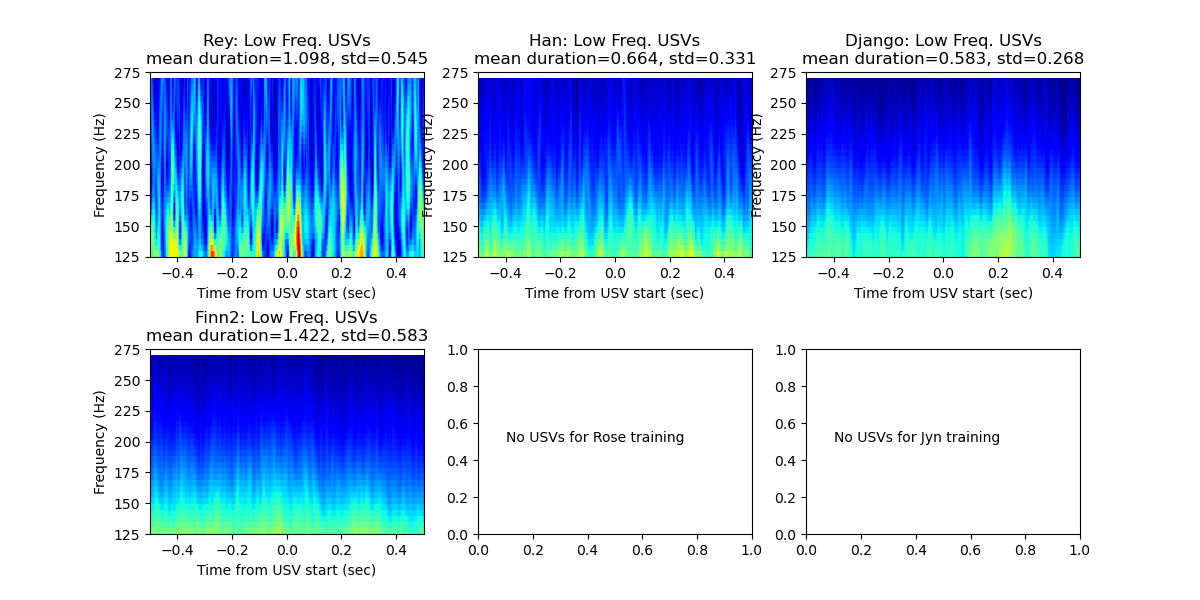

In [33]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
swr_freq_lims = [125, 275]
usv_buffer_sec = (0.5, 0.5)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
    
    if low_usvs.shape[0] > 0:
        wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(low_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims, ax=a)
        a.set_xlabel('Time from USV start (sec)')
        # Insert line break for title
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [34]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_swr_low_usv_onset.png')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

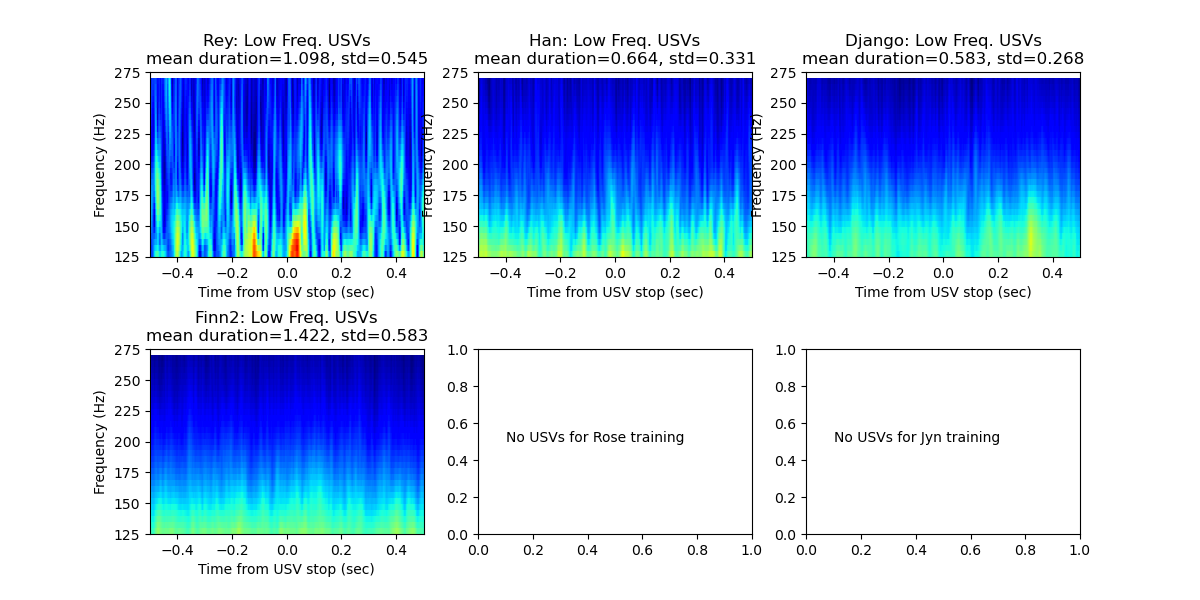

In [45]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
swr_freq_lims = [125, 275]
usv_buffer_sec = (0.5, 0.5)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
    
    if low_usvs.shape[0] > 0:
        wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(low_usvs['stop'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims, ax=a)
        a.set_xlabel('Time from USV stop (sec)')
        # Insert line break for title
        title_text = f"{animal}: Low Freq. USVs\nmean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [46]:
fig.savefig('/home/bowenw/Documents/thesisplots/group_swr_low_usv_offset.png')

test
test2


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

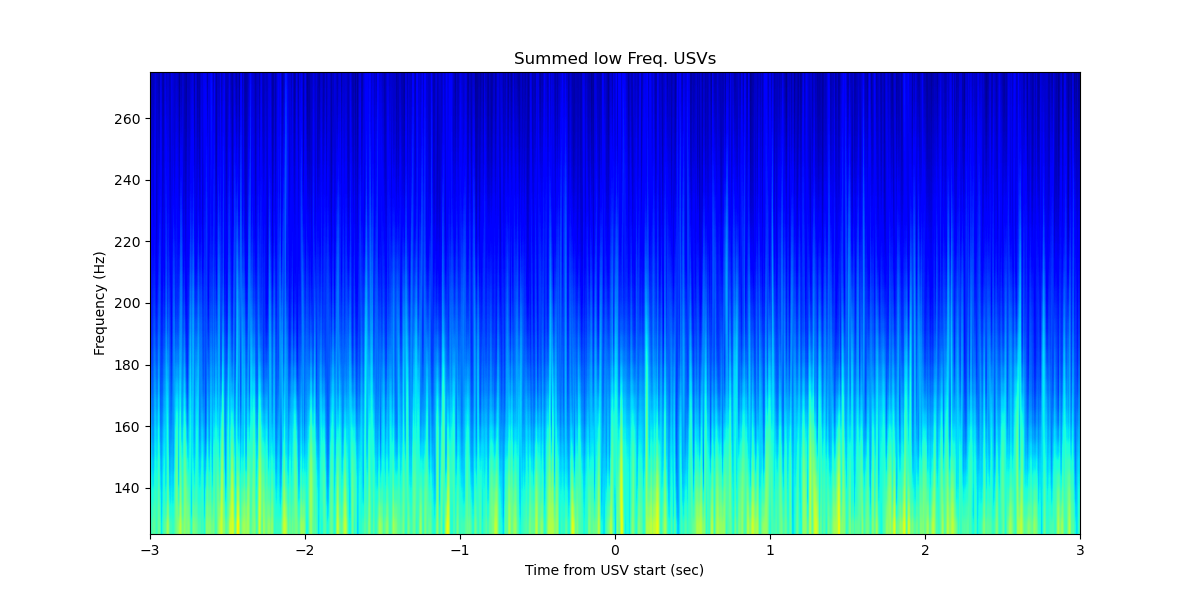

In [11]:
#low USV Sum up all animals
fig, ax = plt.subplots(figsize=(12, 6))
freq_thresh = 22
swr_freq_lims = [125,275]
usv_buffer_sec = (3, 3)
summed_traces = None
n_sessions_with_usvs = 0


for (animal, sess_name), sess, usv_epochs in zip(training_sessions, rec_list, usv_list):
    low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
    
    if low_usvs.shape[0] > 0:
        wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(low_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                        ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        if summed_traces is None:
            summed_traces = wv_swr_mean.traces 
        else:
            summed_traces += wv_swr_mean.traces  

        n_sessions_with_usvs += 1


if n_sessions_with_usvs > 0:
    plot_spectrogram(summed_traces, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims, ax=ax)
    ax.set_xlabel('Time from USV start (sec)')
    ax.set_title("Summed low Freq. USVs")
else:
    print("cannot plot")

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

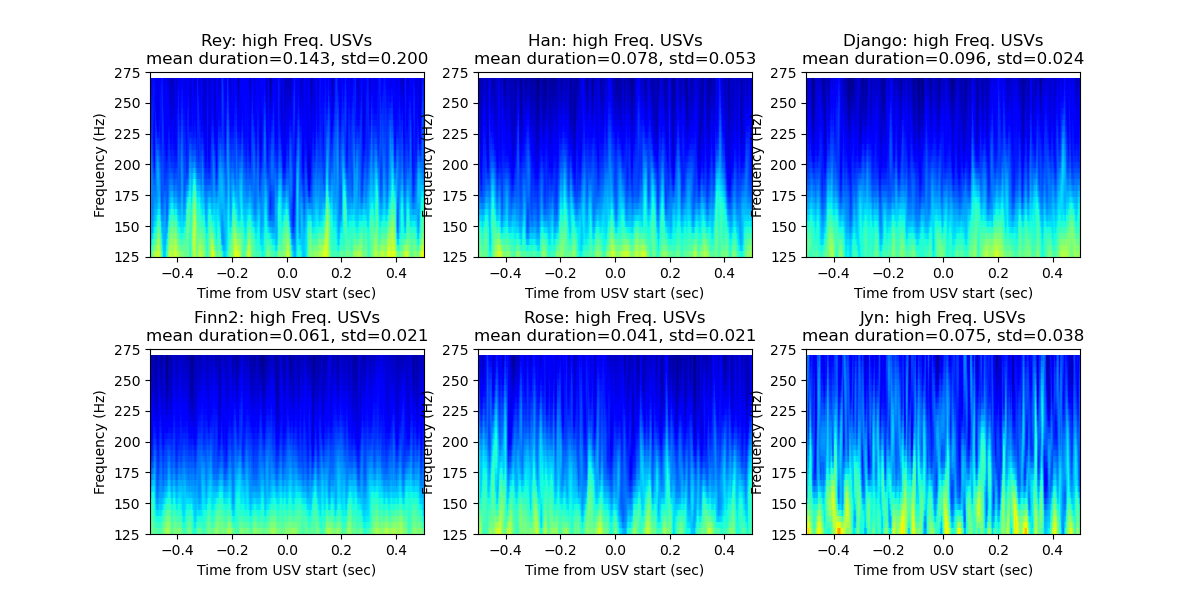

In [40]:
# Plot high USVs starts for all animals
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
swr_freq_lims = [125, 275]
usv_buffer_sec = (0.5, 0.5)
fig1, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
    
    if high_usvs.shape[0] > 0:
        wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(high_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims, ax=a)
        a.set_xlabel('Time from USV start (sec)')
        # Insert line break for title
        title_text = f"{animal}: high Freq. USVs\nmean duration={high_usvs.Duration.mean():.3f}, std={high_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [41]:
fig1.savefig('/home/bowenw/Documents/thesisplots/group_swr_high_usv_onset.png')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

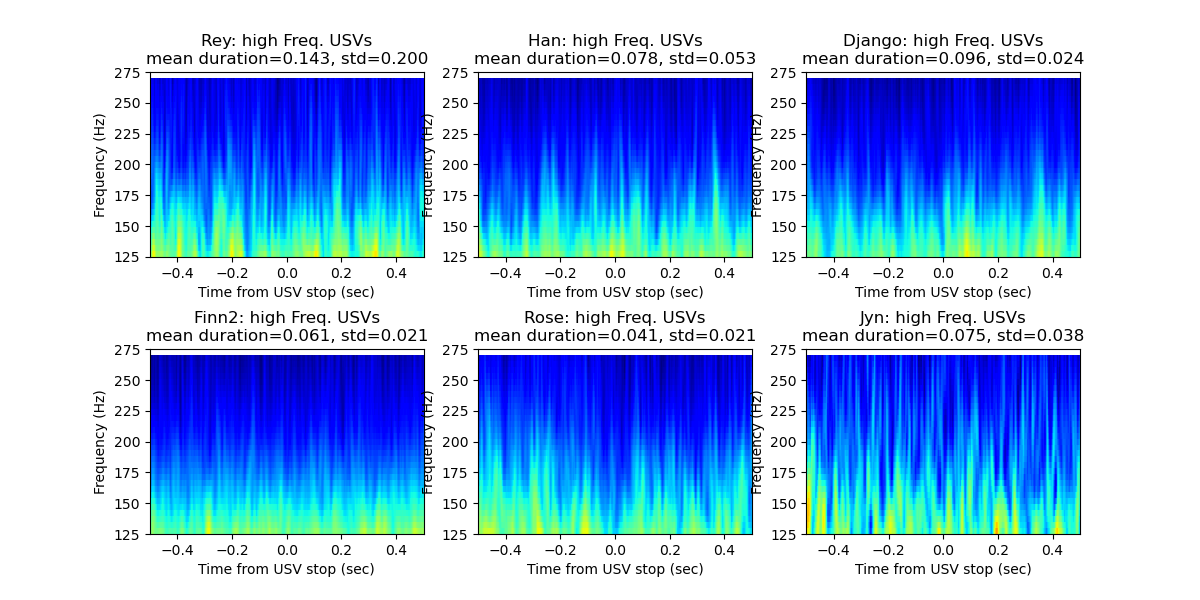

In [42]:
# Plot high USVs starts for all animals
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

freq_thresh = 22
swr_freq_lims = [125, 275]
usv_buffer_sec = (0.5, 0.5)
fig2, ax = plt.subplots(2, 3, figsize=(12, 6))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax.reshape(-1)):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
    
    if high_usvs.shape[0] > 0:
        wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(high_usvs['stop'].values, buffer_sec=usv_buffer_sec, 
                                                       ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims, ax=a)
        a.set_xlabel('Time from USV stop (sec)')
        # Insert line break for title
        title_text = f"{animal}: high Freq. USVs\nmean duration={high_usvs.Duration.mean():.3f}, std={high_usvs.Duration.std():.3f}"
        a.set_title(title_text)
    else:
        a.text(0.1, 0.5, f"No USVs for {animal} {sess_name}")

plt.subplots_adjust(hspace=0.5)

In [44]:
fig2.savefig('/home/bowenw/Documents/thesisplots/group_swr_high_usv_offset.png')

test
test2


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

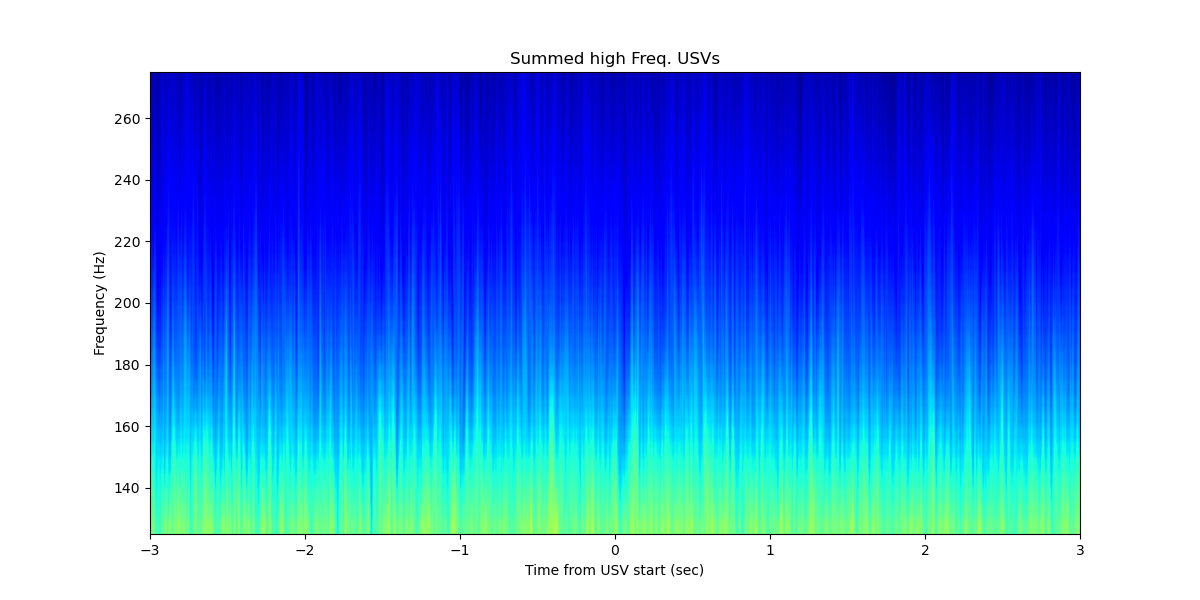

In [16]:
#high USV Sum up all animals
fig, ax = plt.subplots(figsize=(12, 6))
freq_thresh = 25
swr_freq_lims = [125, 275]
usv_buffer_sec = (3, 3)
summed_traces = None
n_sessions_with_usvs = 0


for (animal, sess_name), sess, usv_epochs in zip(training_sessions, rec_list, usv_list):
    high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
    
    if high_usvs.shape[0] > 0:
        wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(high_usvs['start'].values, buffer_sec=usv_buffer_sec, 
                                                        ignore_epochs=sess.art_epochs, print_ignored_frames=False)
        if summed_traces is None:
            summed_traces = wv_swr_mean.traces 
        else:
            summed_traces += wv_swr_mean.traces  

        n_sessions_with_usvs += 1


if n_sessions_with_usvs > 0:
    plot_spectrogram(summed_traces, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims, ax=ax)
    ax.set_xlabel('Time from USV start (sec)')
    ax.set_title("Summed high Freq. USVs")
else:
    print("cannot plot")

In [17]:
wv_swr_mean.traces.shape

(30, 7500)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

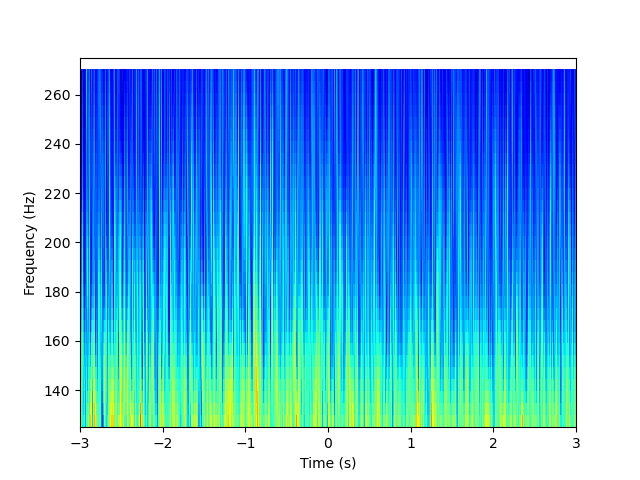

In [18]:
%matplotlib widget
plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

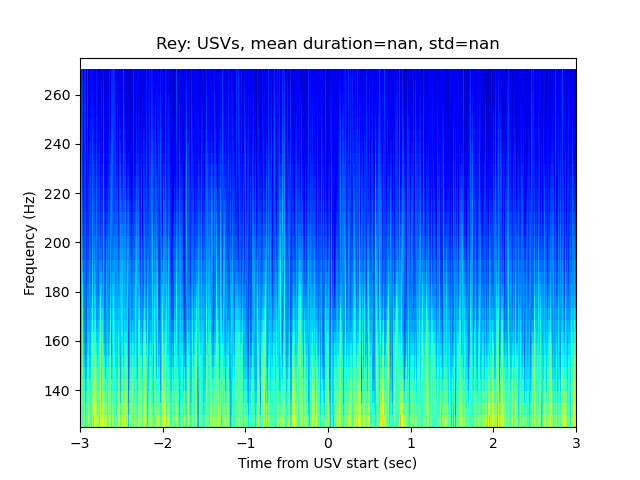

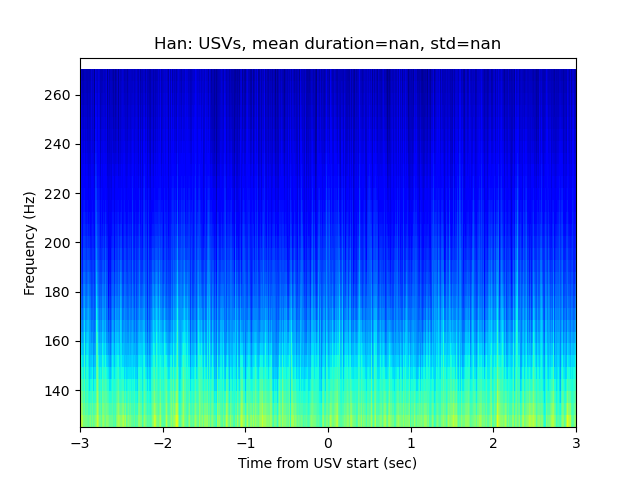

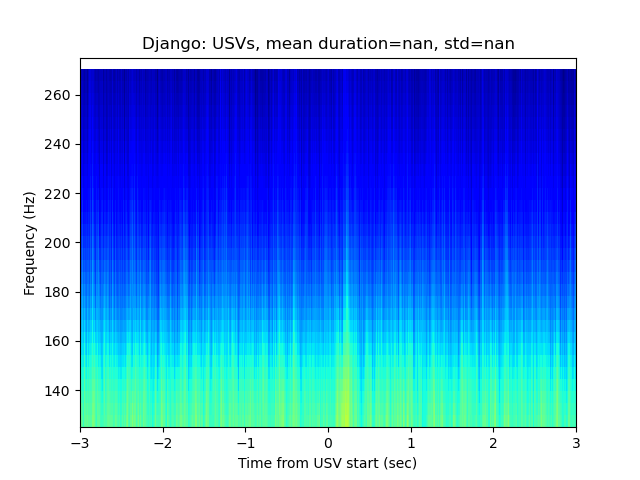

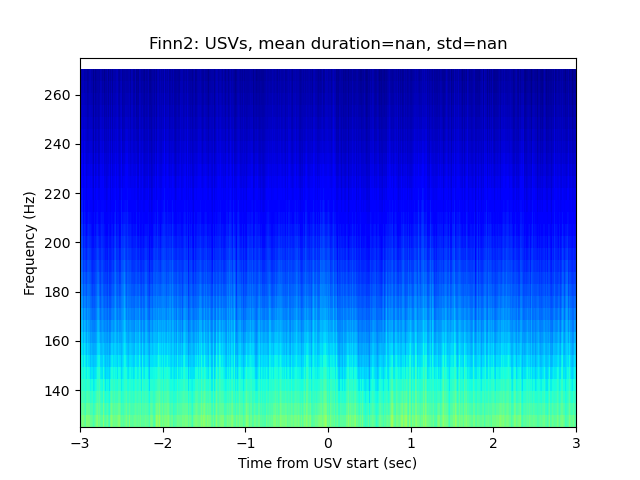

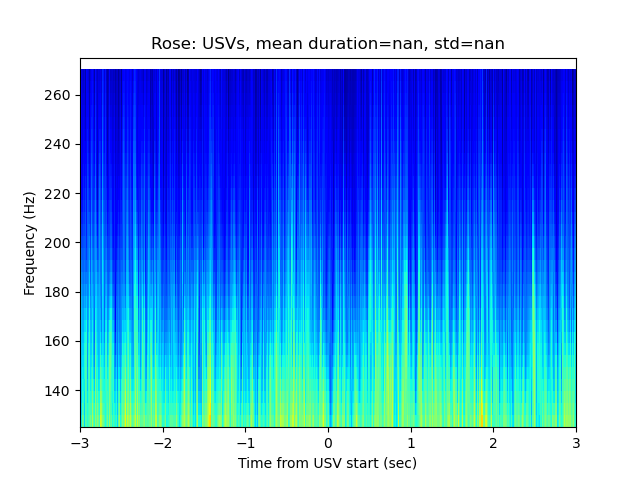

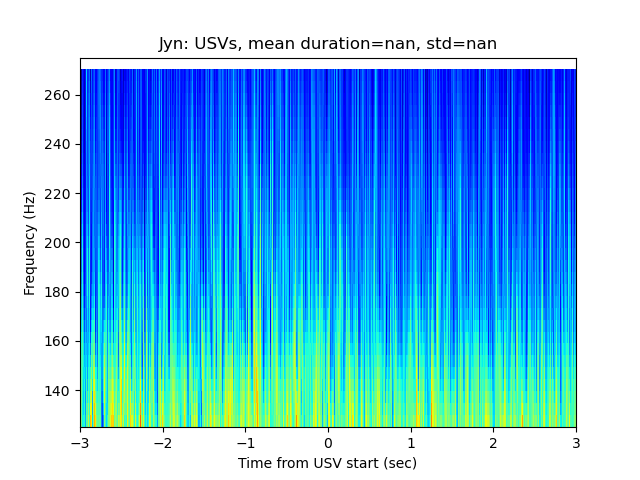

In [19]:
# Plot all USVs for all animals
freq_thresh = None
swr_freq_lims = [125,275]
usv_buffer_sec = (3, 3)

for (animal, sess_name), sess, usv_epochs in zip(training_sessions, rec_list, usv_list):
    
    wv_swr_mean = sess.wv_ripple.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=sess.art_epochs)
    ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
    ax.set_xlabel('Time from USV start (sec)')
    ax.set_title(f"{animal}: USVs, mean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}")